In [251]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy.matlib
import pickle

from scipy import linalg, sparse, stats
from tqdm.notebook import tqdm
from sklearn.preprocessing import normalize, scale
from sklearn.neighbors import kneighbors_graph

In [2]:
GLOVE_PATH = '/mnt/guanabana/raid/data/datasets/GloVe/pretrained/glove.6B.300d.txt'
CAVS_PATH = '../data/filtered_broden_cavs.pickle'
EMBEDDING_PATH = '../data/word_embedding_6B_300D.pickle'
TEXTURE_PATH = "/raid/data/datasets/broden1_384/c_texture.csv"

In [3]:
textures = pd.read_csv(TEXTURE_PATH, index_col = 0)
texture_list = list(textures['name'])

Read the concept activation vectors from the Broden dataset as a dictionary

In [4]:
with open(CAVS_PATH, 'rb') as handle:
        cavs_broden = pickle.load(handle)

Extract the word embeddings from the GloVe dataset. The word embeddings are stored in a dictionary, with the word as key and vector as value, and in a matrix (400 000 x 300). The dataset contains about 400K words.

In [5]:
if os.path.exists(EMBEDDING_PATH):
    with open(EMBEDDING_PATH, 'rb') as handle:
        embedding_dict = pickle.load(handle)

    glove_embedding_matrix = np.load('../data/glove_embedding_matrix.npy')
else:
    embedding_dict = {}
    glove_embedding_matrix = np.zeros((400000, 300))

    with open(GLOVE_PATH, 'r', encoding="utf-8") as f:
        for i, line in tqdm(enumerate(f)):
            
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], 'float32').reshape(1,-1)
            embedding_dict[word] = vector

            glove_embedding_matrix[i] = vector
                        
    with open(EMBEDDING_PATH, 'wb') as handle:
        pickle.dump(embedding_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
     
    np.save('../data/glove_embedding_matrix.npy', glove_embedding_matrix)

Select the concepts from the Broden dataset, which are also available as word embedding. Several concepts in the Broden dataset end with _'-s'_. This is removed to get more concepts linked with an embedding. 

In [6]:
# list all Broden concepts
all_broden_concepts = list(cavs_broden.keys())

# remove duplicates from concept list (e.g. mountain-s is stored when mountain and mountain-s are both in the dataset)
# and remove the textures from the concepts
no_dups_concepts = [c for c in all_broden_concepts if c +'-s' not in all_broden_concepts and c not in texture_list]

In [7]:
len(all_broden_concepts)

722

In [8]:
# create a matrix of all cavs
cav_matrix = np.zeros((len(no_dups_concepts), cavs_broden[no_dups_concepts[0]]['cav'].shape[1]))
for i in range(len(no_dups_concepts)):
    cav = cavs_broden[no_dups_concepts[i]]['cav']
    cav_matrix[i] = cav

# remove the '-s' from the concepts if present 
broden_concepts = [c[:-2] if c[-2:] == '-s' else c for c in no_dups_concepts]

In [9]:
cav_matrix.shape

(649, 2048)

Remove the '-s' from the _scene_ concepts and store the matching cavs with the word embeddings. The index is stored to remove the unavailable concepts from the CAV matrix

In [10]:
embedding_ix_concepts = [(idx, c) for idx, c in enumerate(broden_concepts) if c in embedding_dict.keys()]

# store the indices of concepts which are present in both datasets
embedding_idxs = [ix for ix, n in embedding_ix_concepts]
embedding_concepts = [c for ix, c in embedding_ix_concepts]

In [11]:
print("The amount of CAVs with a corresponding word embedding: ", len(embedding_idxs))

The amount of CAVs with a corresponding word embedding:  373


In [12]:
cavs_with_embedding = cav_matrix[embedding_idxs]

In [13]:
cavs_with_embedding.shape

(373, 2048)

Create a matrix of the word embeddings for the concepts which also have a CAV.

In [14]:
embeddings_with_cav = np.zeros((len(embedding_idxs), 300))
for i in range(len(embedding_concepts)):
    word_vec = embedding_dict[embedding_concepts[i]].reshape(1,-1)
    embeddings_with_cav[i] = word_vec

In [15]:
embeddings_with_cav.shape

(373, 300)

Create matrix with CAVs which do not have a matching word embedding

In [16]:
cav_no_glove = np.delete(cav_matrix, embedding_idxs, axis=0)

Create matrix with GloVe embeddings which do not have a matching CAV

In [73]:
glove_no_cav = np.zeros((400000 - len(embedding_concepts), 300))
glove_no_cav_concept = []

idx = 0
for concpt in embedding_dict.keys():
    if concpt not in embedding_concepts:
        glove_no_cav_concept.append(concpt)
        concpt_vec = embedding_dict[concpt]
        glove_no_cav[idx] = concpt_vec
        idx +=1

glove_no_cav_subset = glove_no_cav[:1000]

Concatenate the data together, the first 373 rows have correspondence between the datasets

In [74]:
cavs_sorted = np.concatenate((cavs_with_embedding, cav_no_glove))
glove_sorted = np.concatenate((embeddings_with_cav, glove_no_cav_subset))

In [75]:
cavs_sorted.shape

(649, 2048)

## Manifold alignment

In [76]:
def gen_eig(A, B, option, n_eig):
    """
    Extracts generalized eigenvalues for problem A * U = B * U * landa
    """
    
    
    n_eig = min(n_eig, np.linalg.matrix_rank(A), np.linalg.matrix_rank(B))
    
    B = (B + B.T) / 2
    R = B.shape[0]
    rango = np.linalg.matrix_rank(B)
    
    if rango == R:
        U = np.zeros((R, n_eig))
        D = np.zerose((n_eig, n_eig))
        inv_B = np.linalg.inv(B)
        for k in range(n_eig):
            d, a = sparse.linalg.eigs(np.matmul(inv_B, A),1, which=option) #'a' are the eigenvectors in the matlab code
            d = d.real
            a = a.real
            
            ab = np.matmul(a.T, B)
            a = np.divide(a, np.sqrt(np.matmul(ab, a)))
            U[:,k] = a
            D[k,k] = d
            
            ba = np.matmul(B, a)
            aTb = np.matmul(a.T, B)
            dba = np.matmul(d, ba)
            A = A - np.matmul(dba, aTb)
        
        return U, D, n_eig
    
    else:
        d, v = sparse.linalg.eigs(B, rango)
        d = d.real
        v = v.real
        
        B = np.matmul(v.T, B)
        B = np.matmul(B, v)
        
        A = np.matmul(v.T, A)
        A = np.matmul(A, v)
        
        U2 = np.zeros((rango, n_eig))
        D = np.zeros((n_eig, n_eig))
        inv_B = np.linalg.inv(B)
        
        for k in range(n_eig):
            
            d, a = sparse.linalg.eigs(np.matmul(inv_B, A),1, which=option)
            d = d.real
            a = a.real
            
            ab = np.matmul(a.T, B)
            aba = np.matmul(ab, a)
            a = np.divide(a, np.sqrt(aba))
            
            U2[:,k] = a.flatten()
        
            D[k,k] = d
            
            ba = np.matmul(B, a)
            aTb = np.matmul(a.T, B)
            
            dba = d * ba
            A = A - np.matmul(dba, aTb)
        
        U = np.matmul(v, U2)
        return U, D, n_eig

Normalize the data along each sample.

In [212]:
cavs_norm = normalize(cavs_with_embedding,axis=1)
glove_norm = normalize(embeddings_with_cav,axis=1)

cavs_sorted_norm = normalize(cavs_sorted, axis=1)
glove_sorted_norm = normalize(glove_sorted, axis=1)

Transpose the matrices to column matrices

In [213]:
cavs_norm_col = cavs_norm.T
glove_norm_col = glove_norm.T

cavs_sorted_norm_col = cavs_sorted_norm.T
glove_sorted_norm_col = glove_sorted_norm.T

d1, n1 = cavs_sorted_norm_col.shape
d2, n2 = glove_sorted_norm_col.shape

In [214]:
n1

649

In [216]:
tot_samples = n1+n2
tot_samples

2022

As the data is normalized to norm 1, the multiplication of the matrix with its transpose should show 1s along the diagonal

In [81]:
# plt.imshow(np.matmul(cavs_sorted_norm_col.T, cavs_sorted_norm_col))

To perform manifold allignment the MatLab code from Devis Tuia is followed: https://github.com/dtuia/KEMA/blob/master/general_routine/KMA.m

In [132]:
n_samples = len(embedding_concepts)
MU = 0.99
LAMBDA = 0.5

Compute the adjacency matrices for both the CAV and GloVe data

In [133]:
n_neighbors = 15
cav_knn_graph = kneighbors_graph(cavs_sorted_norm, n_neighbors, mode = 'connectivity')
cav_knn_graph = cav_knn_graph.toarray()

In [134]:
glove_knn_graph = kneighbors_graph(glove_sorted_norm, n_neighbors, mode = 'connectivity', n_jobs = 10)
glove_knn_graph = glove_knn_graph.toarray()

In [135]:
W = linalg.block_diag(cav_knn_graph, glove_knn_graph)

In [136]:
#plt.imshow(W)

Similarity matrix (Ws) encodes the samples belonging to the same class. In this research, there is a pairwise connections, every CAV only has a single match with a word embedding. This relation can be captured by the identity matrix. <br> The corresponding diagonal row sum matrix (Ds) results from summing Ws along the rows and converting the sums to a diagonal matrix.

In [137]:
Ws = np.zeros((n1+n2, n1+n2))

Ws1 = np.eye(n1)
Ws2 = np.eye(n2)
Ws3 = np.eye(n_samples)

Ws[:n1, :n1] = Ws1
Ws[n1:, n1:] = Ws2
Ws[n1:(n1+n_samples), :n_samples] = Ws3
Ws[:n_samples, n1:(n1+n_samples)] = Ws3

Ws = Ws + np.eye(Ws.shape[0])

# the identity matrices of Ws3 are not plotted on the imshow, but when plotting the right coordinates it does appear
#plt.imshow(Ws)

# should be True
Ws[0, n1] == 1

True

The dissimilarity matrix (Wd) encodes which samples do not belong to the same class. This is important to capture, otherwise every sample will end in the same location (the origin) as this will capture the similarity between the samples. In this research it is assumed that every sample is dissimilar from every other sample except from itself.

In [138]:
Wd = np.ones((n1+n2, n1+n2))
np.fill_diagonal(Wd, 0)

Wd1 = np.ones((n_samples, n_samples))
np.fill_diagonal(Wd1, 0)

Wd[:n_samples, n1:(n1+n_samples)] = Wd1
Wd[n1:(n1+n_samples), :n_samples] = Wd1

Wd = Wd + np.eye(Wd.shape[0])

#plt.imshow(Wd)

Wd[n1:n1+5, :5]

array([[0., 1., 1., 1., 1.],
       [1., 0., 1., 1., 1.],
       [1., 1., 0., 1., 1.],
       [1., 1., 1., 0., 1.],
       [1., 1., 1., 1., 0.]])

Normalize the data

In [139]:
Sws = sum(sum(Ws))
Swd = sum(sum(Wd))
Sw = sum(sum(W))

Ws = Ws / Sws * Sw
Wd = Wd / Swd * Sw

Extract the diagionals from the matrices

In [140]:
Dd = np.diag(np.sum(Wd, axis=1))
Ds = np.diag(np.sum(Ws, axis = 1))
D = np.diag(np.sum(W, axis=1))

In [141]:
D.shape

(2022, 2022)

Create the Laplacians which represent the structure of the data

In [142]:
Ls = Ds - Ws # graph Laplacian of similarity 
Ld = Dd - Wd # Laplacian of dissimilarity

L = D - W # Laplacian topology/geometry

In [143]:
A = ((1 - MU) * L + MU * Ls) + LAMBDA * np.eye(Ls.shape[0])
B = Ld

In [144]:
L.shape

(2022, 2022)

In [145]:
A.shape

(2022, 2022)

In [146]:
kernel_cav = np.matmul(cavs_sorted_norm_col.T, cavs_sorted_norm_col)

# #the kernel should have a diagonal of 1s
# plt.imshow(kernel_cav)

In [147]:
kernel_glove = np.matmul(glove_sorted_norm_col.T, glove_sorted_norm_col)
# plt.imshow(kernel_glove)

In [148]:
K = linalg.block_diag(kernel_cav, kernel_glove)

In [149]:
# plt.imshow(K)

In [150]:
KA = np.matmul(K,A)
KB = np.matmul(K,B)

KAK = np.matmul(KA, K)
KBK = np.matmul(KB, K)

In [151]:
# plt.imshow(KBK)

Solve the generalized eigenvalue decomposition

In [152]:
ALPHA, LAMBDA,n_eig = gen_eig(KAK, KBK, 'LM', 4)

Sort the eigenvalues and vectors

In [153]:
lambda_idxs = np.diag(LAMBDA).argsort()
LAMBDA = np.sort(np.diag(LAMBDA))
LAMBDA = LAMBDA.reshape(LAMBDA.shape[0],1)

In [154]:
LAMBDA

array([[0.84407637],
       [0.84761132],
       [0.85263444],
       [1.61716196]])

In [155]:
ALPHA = ALPHA[:, lambda_idxs]

Divide the eigenvectors over the 2 datasets

In [156]:
E1 = ALPHA[:n1, :] #eigenvectors for the first dataset (CAV)
E2 = ALPHA[n1:, :] #eigenvectors for the second dataset (GloVe)

Rotate axis is necessary

In [157]:
sourceXpInv = (-1 * np.matmul(E1.T, kernel_cav)).T
sourceXp = np.matmul(E1.T, kernel_cav).T
targetXp = np.matmul(E2.T, kernel_glove).T

In [158]:
sourceXpInv = stats.zscore(sourceXpInv)
sourceXp = stats.zscore(sourceXp)
targetXp = stats.zscore(targetXp)

In [159]:
sourceXpInv.shape

(649, 4)

In [160]:
ErrRec = np.zeros((n1, ALPHA.shape[1]))
ErrRecInv = np.zeros((n1, ALPHA.shape[1]))

In [161]:
m1 = np.zeros((n1, ALPHA.shape[1]))
m1inv = np.zeros((n1, ALPHA.shape[1]))
m2 = np.zeros((n1, ALPHA.shape[1]))

In [162]:
cls = np.arange(n1).reshape(-1,1)

Compare the error of the inverted eigenvectors and the normal eigenvectors

In [163]:
for j in range(ALPHA.shape[1]):
    for i in range(n1):
        m1inv[i,j] = np.mean(sourceXpInv[i, j])
        #print('m1inv: ', m1inv)
        m1[i,j] = np.mean(sourceXp[i, j])
        #print('m1: ', m1)
        m2[i,j] = np.mean(targetXp[i, j])
        #print('m2: ', m2)
        
        ErrRec[i,j] = np.square(np.power(np.mean(sourceXp[i, j]) - np.mean(targetXp[i, j]), 2))
        
        ErrRecInv[i,j] = np.square(np.power(np.mean(sourceXpInv[i, j]) - np.mean(targetXp[i, j]),2))
        


In [164]:
Sc = ErrRec.max(axis=0) > ErrRecInv.max(axis=0)

In [165]:
Sc

array([ True,  True,  True,  True])

Invert axis if necessary

In [166]:
ALPHA[:n1, Sc] = ALPHA[:n1, Sc] * -1

In [167]:
NF = 100

In [168]:
nVectLin = min(NF, np.linalg.matrix_rank(KBK))
nVectLin = min(nVectLin, np.linalg.matrix_rank(KAK))

Transform data

In [200]:
T1 = cavs_sorted_norm_col.shape[1]
T2 = glove_sorted_norm_col.shape[1]

for Nf in range(nVectLin):
    E1 = ALPHA[:n1, :Nf+1]
    E2 = ALPHA[n1:, :Nf+1]
    
    Phi1toF = np.matmul(E1.T, kernel_cav)
    Phi2toF = np.matmul(E2.T, kernel_glove)
    
    Phi1TtoF = np.matmul(E1.T, kernel_cav) #KT1?
    Phi2TtoF = np.matmul(E2.T, kernel_glove) #KT2?
    
    m1 = np.mean(Phi1toF.T, axis = 0)
    m2 = np.mean(Phi2toF.T, axis = 0)
    s1 = np.std(Phi1toF.T, axis = 0)
    s2 = np.std(Phi2toF.T, axis =0)
    
    #Phi1toF = stats.zscore(Phi1toF).T
    #Phi2toF = stats.zscore(Phi2toF).T
    
    Phi1TtoF = np.divide((Phi1TtoF.T - np.matlib.repmat(m1, T1, 1)), 
                         np.matlib.repmat(s1, T1, 1)).T
    
    Phi2TtoF = np.divide((Phi2TtoF.T - np.matlib.repmat(m2, T2 ,1)),
                         np.matlib.repmat(s2, T2, 1)).T

In [208]:
# Phi1TtoF_Lin = Phi1TtoF
# Phi2TtoF_Lin = Phi2TtoF

# Phi1TtoF_Lin = scale(Phi1TtoF, axis=0)
# Phi2TtoF_Lin = scale(Phi2TtoF, axis=0)

# Phi1TtoF_Lin = normalize(Phi1TtoF_Lin, axis=0)
# Phi2TtoF_Lin = normalize(Phi2TtoF_Lin, axis=0)


Phi1TtoF_Lin = normalize(Phi1TtoF, axis = 0)
Phi2TtoF_Lin = normalize(Phi2TtoF, axis = 0)

# Phi1TtoF_Lin = stats.zscore(Phi1TtoF, axis = 0)
# Phi2TtoF_Lin = stats.zscore(Phi2TtoF, axis = 0)


Text(0.6549995054372064, 0.6451679736252596, 'church')

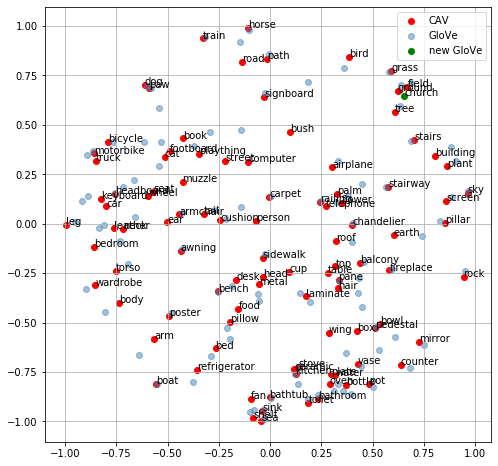

In [209]:
num_concepts = 100

new_glove = 500

plt.figure(figsize=(8,8))
plt.grid()
plt.scatter(Phi1TtoF_Lin[0,:num_concepts], Phi1TtoF_Lin[1,:num_concepts], label = 'CAV', color = 'red')
plt.scatter(Phi2TtoF_Lin[0,:num_concepts], Phi2TtoF_Lin[1,:num_concepts], label = 'GloVe', color = 'steelblue', alpha=0.5)
plt.scatter(Phi2TtoF_Lin[0,n_samples + new_glove], Phi2TtoF_Lin[1,n_samples + new_glove], label = 'new GloVe', color='green')
#plt.xlim([-2.5,2.5])
#plt.ylim([-2.5, 2.5])


plt.legend()

for ii, txt in enumerate(embedding_concepts[:num_concepts]):
    plt.annotate(txt, (Phi1TtoF_Lin[0,ii], Phi1TtoF_Lin[1,ii]))
#     plt.annotate(txt, (Phi2TtoF_Lin[0,ii], Phi2TtoF_Lin[1,ii]))

plt.annotate(glove_no_cav_concept[new_glove], (Phi2TtoF_Lin[0,n_samples + new_glove], Phi2TtoF_Lin[1,n_samples+new_glove]))

## Explore new concepts related to scenicness

### Compare GloVe concepts to the clusters

### Convert GloVe to CAV

The GloVe concepts are transformed to CAVs and then each new GloVe concepts is compared to scenicness using Kendalls Tau rank correlation

In [284]:
test_data = glove_no_cav[1000:10000].T
test_data = normalize(test_data, axis=0)
test_data.shape

(300, 9000)

In [285]:
test_kernel = np.matmul(test_data.T, glove_sorted_norm_col)
test_kernel.shape

(9000, 1373)

In [286]:
test_transform = np.matmul(E2.T, test_kernel.T)
test_transform.shape

(4, 9000)

In [287]:
T3 = test_data.shape[1]

In [288]:
new_concepts_in_latent = np.divide((test_transform.T - np.matlib.repmat(m2, T3 ,1)),
                         np.matlib.repmat(s2, T3, 1)).T

In [289]:
new_c_to_cav = np.multiply((new_concepts_in_latent.T + np.matlib.repmat(m1,T3,1)),
                          np.matlib.repmat(s1, T3, 1)).T

In [290]:
new_concepts_cav = np.matmul(np.linalg.pinv(E1.T), new_c_to_cav)
new_concepts_cav.shape

(649, 9000)

In [291]:
new_concepts_cav = np.matmul(np.linalg.pinv(cavs_sorted_norm_col).T, new_concepts_cav)

In [292]:
new_concepts_cav.shape

(2048, 9000)

---

In [281]:
with open('../data/son_tensors.pickle', 'rb') as handle:
        son_tensors = pickle.load(handle)

In [293]:
concept_score_matrix = np.zeros((len(son_tensors), new_concepts_cav.shape[1]))

In [283]:
for i in tqdm(range(len(son_tensors))):
    son_img_tensor = son_tensors[list(son_tensors.keys())[i]][2].numpy()
    
    for c in range(new_concepts_cav.shape[1]):
        concept_score = np.dot(new_concepts_cav[:,c], son_img_tensor)
        concept_score_matrix[i][c] = concept_score

KeyboardInterrupt: 

In [258]:
son_tensors['0']

['1',
 '/raid/data/datasets/SoN/images/4/1.jpg',
 tensor([0.3566, 1.4949, 0.1739,  ..., 0.0140, 0.2987, 0.0557])]